In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn import metrics
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models
import torch.optim as optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from collections import OrderedDict


In [2]:
# Set based on whether running locally or on colab
COLAB = True

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/data/mnm2_processed_data_slices.zip"

Streaming output truncated to the last 5000 lines.
  inflating: mnm2_processed_data_slices/train/images/041_SA_ES_0006.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._041_SA_ES_0006.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/083_SA_ES_0009.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._083_SA_ES_0009.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/054_SA_ED_0000.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._054_SA_ED_0000.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/098_SA_ES_0003.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._098_SA_ES_0003.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/019_SA_ES_0007.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slices/train/images/._019_SA_ES_0007.nii.gz  
  inflating: mnm2_processed_data_slices/train/images/067_SA_ED_0006.nii.gz  
  inflating: __MACOSX/mnm2_processed_data_slice

In [5]:
data_folder = '/content/mnm2_processed_data_slices/'

#### Create Dataset

In [6]:
class MnM2Dataset(Dataset):
    def __init__(self, root_dir, train=False, test=False, transform=None, remove_no_mask=False):
        super().__init__()
        self.root_dir = root_dir
        self.train=train
        self.test=test
        self.transform = transform
        self.remove_no_mask = remove_no_mask

        if self.train:
            self.image_dir = self.root_dir + 'train/images/'
            self.label_dir = self.root_dir + 'train/labels/'
        elif self.test:
            self.image_dir = self.root_dir + 'test/images/'
            self.label_dir = self.root_dir + 'test/labels/'
        else:
            self.image_dir = self.root_dir + 'valid/images/'
            self.label_dir = self.root_dir + 'valid/labels/'

        self.image_files = sorted([f for f in os.listdir(self.image_dir)])
        self.label_files = sorted([f for f in os.listdir(self.label_dir)])

        if remove_no_mask:
            self.filtered_files = self.filter_images_with_masks()
        else:
            self.filtered_files = list(range(len(self.image_files)))

    def __len__(self):
        return len(self.filtered_files)

    def __getitem__(self, index):
        filtered_index = self.filtered_files[index]
        #print(f"Index: {index}, Actual Index: {filtered_index}, Type of actual_idx: {type(filtered_index)}")

        image_path = os.path.join(self.image_dir, self.image_files[filtered_index])
        label_path = os.path.join(self.label_dir, self.label_files[filtered_index])
        image = nib.load(image_path).get_fdata().astype(np.float32)
        label = nib.load(label_path).get_fdata().astype(np.float32)
        label = np.where(label == 3, 1.0, 0.0).astype(np.float32) # keep label=3 (RV) only
        '''
        image = transforms.ToPILImage()(image)
        image = transforms.Resize((256, 256))(image)
        image = transforms.ToTensor()(image)
        label = transforms.ToPILImage()(label)
        label = transforms.Resize((256, 256))(label)
        label = transforms.ToTensor()(label)
        '''

        image = image/(image.max()/255.0)
        image = image.astype(np.uint8)

        image = transforms.ToTensor()(image)
        label = transforms.ToTensor()(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

    def filter_images_with_masks(self):
        index_with_masks = []
        for idx, label_file in enumerate(self.label_files):
            label_path = os.path.join(self.label_dir, label_file)
            label = nib.load(label_path).get_fdata().astype(np.float32)
            label = np.where(label == 3, 1.0, 0.0).astype(np.float32) # keep label=3 (RV) only

            if np.any(label > 0): index_with_masks.append(idx)

        return index_with_masks

In [7]:
train_dataset = MnM2Dataset(data_folder, train=True, transform=None, remove_no_mask=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, drop_last=False, num_workers=0)

In [8]:
data_iter = iter(train_loader)
(image, label) = next(data_iter)

In [9]:
print(image.min())
print(image.max())

tensor(0.)
tensor(1.)


In [10]:
print(label.min())
print(label.max())

tensor(0.)
tensor(1.)


In [11]:
print(image.size())
print(label.size())

torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320])


#### Model

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64):
        super(UNet, self).__init__()

        features = init_features

        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.conv(dec1)

        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True))

                ]
            )
        )

#### Loss Function

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-10):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        smooth = 1e-10  # smoothing factor to prevent division by zero
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-10):

        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

#### Model Training

In [76]:
directory='./data/mnm2_processed_data_slices/' #directory to the data
checkpoint_dir='./checkpoints' #directory to the data
tb_logs_dir = './runs' # tensorboard logs

if COLAB:
    directory='./mnm2_processed_data_slices/' #directory to the data
    checkpoint_dir='./gdrive/MyDrive/Colab Notebooks/mnm2 segmentation/checkpoints' #directory to the data
    tb_logs_dir = './gdrive/MyDrive/Colab Notebooks/mnm2 segmentation/runs' # tensorboard logs

lr = 1e-3 #learning rate
num_epochs = 30 # number of epochs
batch_size = 1 # batch size

In [90]:
model_name = 'unet'

run_info = f'{model_name}'
writer = SummaryWriter(f'{tb_logs_dir}/{run_info}')

model = UNet() #initialise the model

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)

optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=1e-4) #define the optimiser as Adam
#optimizer = optim.SGD(model.parameters(), lr= lr, weight_decay=0.1, momentum=0.9) #define the optimiser as SGD

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=4, factor=.3, threshold=1e-4) #define a scheduler that decreases the learning rate if there has been no reduction in validation loss is four epochs


train_transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.CenterCrop(256)
    #transforms.RandomRotation(25)
])


valid_transform = transforms.Compose([
    #transforms.ToTensor(),
    transforms.CenterCrop(256)
])


train_dataset = MnM2Dataset(data_folder, train=True, transform=train_transform, remove_no_mask=True)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
valid_dataset = MnM2Dataset(data_folder, train=False, transform=valid_transform, remove_no_mask=True)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)

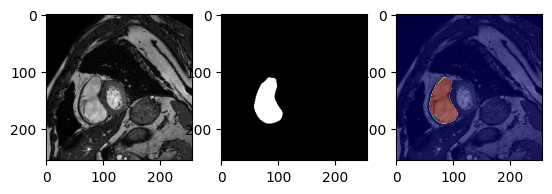

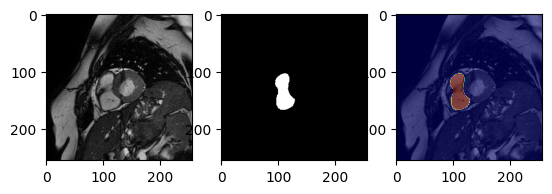

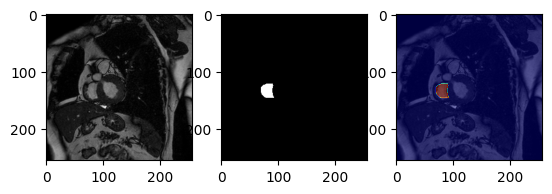

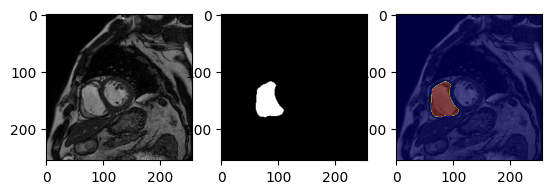

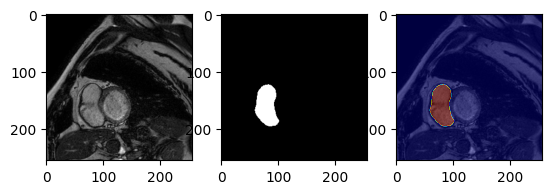

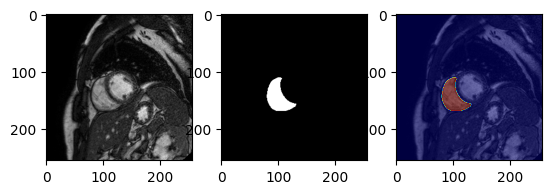

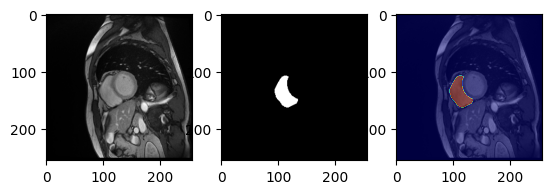

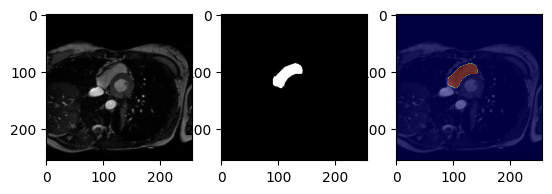

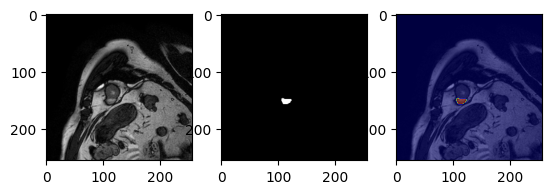

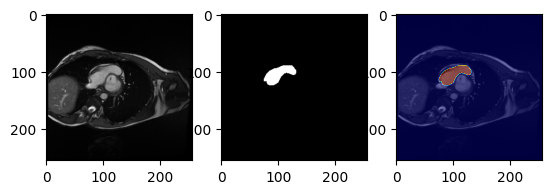

In [91]:
count = 0
for image, label in train_loader:

  count += 1

  img = image.squeeze(0).permute((1, 2, 0)).contiguous()
  lab = label.squeeze(0).permute((1, 2, 0)).contiguous()


  # Plot the image
  _, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(img, cmap='gray')
  ax2.imshow(lab, cmap='gray')
  ax3.imshow(img, cmap='gray')
  ax3.imshow(lab, cmap='jet', alpha = 0.5)

  #print(image.min())
  #print(image.max())

  #print(label.min())
  #print(label.max())


  if count >= 10: break

#### Training Loop

In [92]:
'''
def dice_coefficient(pred_mask, mask, smooth=1e-10):
  with torch.no_grad():
        pred_mask = torch.sigmoid(pred_mask)
        #pred_mask = pred_mask[pred_mask > 0.5].float()
        pred_mask[pred_mask<=0.5] = 0
        pred_mask[pred_mask>0.5] = 1

        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        #print('label',true_label)
        intersect = torch.sum(pred_mask * mask)
        union = torch.sum(pred_mask) + torch.sum(pred_mask)
        dice = (2.0 * intersect + smooth) / (union + smooth)
        return dice
'''
def dice_coefficient(pred_mask, mask):
  with torch.no_grad():
        pred_mask = torch.sigmoid(pred_mask)
        #pred_mask = pred_mask[pred_mask > 0.5].float()
        pred_mask[pred_mask<=0.5] = 0
        pred_mask[pred_mask>0.5] = 1

        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        #print('label',true_label)
        intersect = float(torch.sum(pred_mask * mask).item())
        union = float(torch.sum(pred_mask).item() + torch.sum(mask).item())
        if union==0:
          dice=0
        else: dice = (2.0 * intersect) / union
        return dice

In [93]:
early_trigger = 10 #if the validation AUC hasn't increased in ten epochs, stop the training
early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
best_val_dsc = 0
#for loop for each epoch
for epoch in range(num_epochs):
    st = time.time()
    #get learning rate
    current_lr = lr

    losses = []
    dscs = []
    model.train()
    #loop through each MRI in the training set
    print('Running training..')
    with tqdm(total=len(train_loader)) as pbar:
        for i, (image, label) in enumerate(train_loader):
            optimizer.zero_grad()

            image = image.float().to(device)
            label = label.float().to(device)

            #pass the MRI through the model
            prediction = model.forward(image.float())

            #calculate the loss
            loss = torch.nn.BCEWithLogitsLoss()(prediction, label)
            #loss = DiceLoss()(prediction, label)
            #loss = DiceBCELoss()(prediction, label)

            loss.backward() #back propagation
            optimizer.step() #update weights

            loss_value = loss.item()
            losses.append(loss_value)

            dsc = dice_coefficient(prediction, label)
            dscs.append(dsc)

            train_loss = np.round(np.mean(losses), 4)
            train_dsc = np.round(np.mean(dscs), 4)
            #train_dsc = np.round(np.mean([dsc.cpu().numpy() for dsc in dscs]), 4)


            #print(f'train_loss: {train_loss}')
            pbar.update(1)


    #evaluate the model on the validation data after each epoch
    _ = model.eval()
    losses = []
    dscs = []
    print('Running validation..')
    with tqdm(total=len(valid_loader)) as pbar:
        for i, (image, label) in enumerate(valid_loader):

            image = image.float().to(device)
            label = label.float().to(device)

            prediction = model.forward(image.float())

            loss = torch.nn.BCEWithLogitsLoss()(prediction, label)
            #loss = DiceLoss()(prediction, label)
            #loss = DiceBCELoss()(prediction, label)

            loss_value = loss.item()
            losses.append(loss_value)

            dsc = dice_coefficient(prediction, label)
            dscs.append(dsc)

            val_loss = np.round(np.mean(losses), 4)
            val_dsc = np.round(np.mean(dscs), 4)
            #val_dsc = np.round(np.mean([dsc.cpu().numpy() for dsc in dscs]), 4)
            pbar.update(1)

    if val_dsc > best_val_dsc:
        best_val_dsc = val_dsc
        early_stop=0
    else:
        early_stop+= 1

    # Save model every few epochs (or even more often if you have the disk space).
    if epoch % 2 == 0:
        torch.save(model.state_dict(),
                   os.path.join(checkpoint_dir, "checkpoint_{}_epoch_{}".format(model_name, epoch)))

    if early_stop == early_trigger:
        print('Early stopping after {} epochs'.format(epoch))
        # save model
        torch.save(model.state_dict(),
                   os.path.join(checkpoint_dir, "checkpoint_{}_epoch_{}".format(model_name, epoch)))
        sys.exit()
    scheduler.step(val_loss)

    print(f'Execution Time: {time.strftime("%H:%M:%S", time.gmtime(time.time() - st))}')
    print("epoch : {0} | train loss : {1} | train dsc : {2} | val loss {3} | val dsc {4}".format(
      epoch, train_loss, train_dsc, val_loss, val_dsc))

    # tensorboard logging
    writer.add_scalars("Loss", {"training_loss": train_loss, "validation_loss": val_loss}, epoch)
    writer.add_scalars("DSC", {"training_dsc": train_dsc, "validation_dsc": val_dsc}, epoch)

    print('-' * 30)


writer.close()
writer.flush()

Running training..


100%|██████████| 1327/1327 [01:48<00:00, 12.28it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 34.53it/s]


Execution Time: 00:01:54
epoch : 0 | train loss : 0.078 | train dsc : 0.0379 | val loss 0.0596 | val dsc 0.0
------------------------------
Running training..


100%|██████████| 1327/1327 [01:49<00:00, 12.16it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 36.61it/s]


Execution Time: 00:01:54
epoch : 1 | train loss : 0.0459 | train dsc : 0.2361 | val loss 0.0386 | val dsc 0.3359
------------------------------
Running training..


100%|██████████| 1327/1327 [01:47<00:00, 12.32it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 36.80it/s]


Execution Time: 00:01:53
epoch : 2 | train loss : 0.0281 | train dsc : 0.591 | val loss 0.0287 | val dsc 0.4654
------------------------------
Running training..


100%|██████████| 1327/1327 [01:46<00:00, 12.46it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 37.37it/s]


Execution Time: 00:01:51
epoch : 3 | train loss : 0.0188 | train dsc : 0.719 | val loss 0.1025 | val dsc 0.0
------------------------------
Running training..


100%|██████████| 1327/1327 [01:44<00:00, 12.64it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.20it/s]


Execution Time: 00:01:50
epoch : 4 | train loss : 0.0158 | train dsc : 0.7648 | val loss 0.0279 | val dsc 0.3938
------------------------------
Running training..


100%|██████████| 1327/1327 [01:44<00:00, 12.70it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.14it/s]


Execution Time: 00:01:49
epoch : 5 | train loss : 0.0145 | train dsc : 0.7867 | val loss 0.0361 | val dsc 0.3346
------------------------------
Running training..


100%|██████████| 1327/1327 [01:44<00:00, 12.71it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.16it/s]


Execution Time: 00:01:49
epoch : 6 | train loss : 0.0122 | train dsc : 0.8182 | val loss 0.0132 | val dsc 0.7293
------------------------------
Running training..


100%|██████████| 1327/1327 [01:43<00:00, 12.82it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.43it/s]


Execution Time: 00:01:48
epoch : 7 | train loss : 0.0124 | train dsc : 0.8146 | val loss 0.2811 | val dsc 0.2239
------------------------------
Running training..


100%|██████████| 1327/1327 [01:43<00:00, 12.88it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.35it/s]


Execution Time: 00:01:48
epoch : 8 | train loss : 0.0123 | train dsc : 0.812 | val loss 0.0188 | val dsc 0.5605
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.90it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.02it/s]


Execution Time: 00:01:47
epoch : 9 | train loss : 0.01 | train dsc : 0.8402 | val loss 0.0223 | val dsc 0.5206
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.90it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 37.03it/s]


Execution Time: 00:01:48
epoch : 10 | train loss : 0.01 | train dsc : 0.8497 | val loss 0.0603 | val dsc 0.1631
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.93it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.44it/s]


Execution Time: 00:01:47
epoch : 11 | train loss : 0.0096 | train dsc : 0.8531 | val loss 0.029 | val dsc 0.5054
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.95it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 39.00it/s]


Execution Time: 00:01:47
epoch : 12 | train loss : 0.007 | train dsc : 0.8896 | val loss 0.0225 | val dsc 0.523
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.96it/s]


Running validation..


100%|██████████| 190/190 [00:04<00:00, 38.60it/s]


Execution Time: 00:01:47
epoch : 13 | train loss : 0.0066 | train dsc : 0.8944 | val loss 0.0163 | val dsc 0.625
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.94it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 36.81it/s]


Execution Time: 00:01:48
epoch : 14 | train loss : 0.0063 | train dsc : 0.8979 | val loss 0.0148 | val dsc 0.6325
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.93it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 36.34it/s]


Execution Time: 00:01:47
epoch : 15 | train loss : 0.0062 | train dsc : 0.9 | val loss 0.0173 | val dsc 0.5849
------------------------------
Running training..


100%|██████████| 1327/1327 [01:42<00:00, 12.99it/s]


Running validation..


100%|██████████| 190/190 [00:05<00:00, 37.72it/s]


Early stopping after 16 epochs


SystemExit: 

#### Model Testing

In [97]:
model_test = UNet()

# load model from checkpoints
which_epoch = 14
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_{}_epoch_{}".format(model_name, which_epoch))

if torch.cuda.is_available():
  model_state = torch.load(checkpoint_path)
else:
  model_state = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model_test.load_state_dict(model_state)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model_test.to(device)

#initialise the test datasets (class we defined earlier) and then initialise a Pytorch's dataloader
test_dataset = MnM2Dataset(directory, test=True, transform = valid_transform, remove_no_mask=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)


<ipython-input-97-fc4192c3f83c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(checkpoint_path)


#### Testing Loop

In [98]:
with torch.no_grad(): # to prevent cuda out of memory
  _ = model_test.eval()
  test_dscs = []

  print('Running testing..')
  with tqdm(total=len(test_loader)) as pbar:
          for i, (image, label) in enumerate(test_loader):
              image = image.to(device)
              label = label.to(device)

              prediction = model_test.forward(image)

              dsc = dice_coefficient(prediction, label)
              test_dscs.append(dsc)

              pbar.update(1)



Running testing..


100%|██████████| 1052/1052 [00:27<00:00, 37.66it/s]


In [99]:
np.mean(test_dscs)

0.6396579154376306

Text(0.5, 1.0, 'DSC: 0.337')

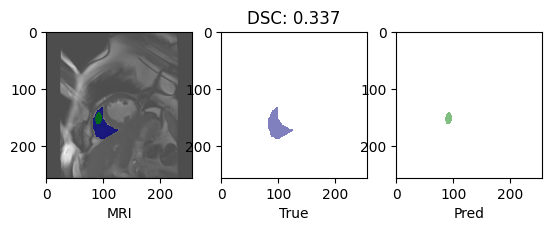

In [89]:
# get an example
data_iter = iter(test_loader)
(image, label) = next(data_iter)


img = image.squeeze(0).permute((1, 2, 0)).contiguous()
lab = label.squeeze(0).permute((1, 2, 0)).contiguous()

image = image.to(device)
label = label.to(device)
prediction = model_test.forward(image)

pred_mask = torch.sigmoid(prediction)
pred_mask[pred_mask<=0.5] = 0
pred_mask[pred_mask>0.5] = 1

pred_dsc = dice_coefficient(pred_mask, label)

# remove background
lab_plt = lab.numpy().copy()
pred_mask_plt = pred_mask.squeeze(0).squeeze(0).cpu().detach().numpy().copy()

lab_plt[lab_plt==0] = np.nan
pred_mask_plt[pred_mask_plt==0] = np.nan

# Plot the image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img, cmap='gray', alpha=0.7)
ax1.imshow(lab_plt, cmap='jet', alpha=0.8)
ax1.imshow(pred_mask_plt, cmap='ocean', alpha=0.8)
ax2.imshow(lab_plt, cmap='jet', alpha = 0.5)
ax3.imshow(pred_mask_plt, cmap='ocean', alpha = 0.5)
#ax3.imshow(lab, cmap='jet', alpha = 0.5)
ax1.set_xlabel('MRI')
ax2.set_xlabel('True')
ax3.set_xlabel('Pred')
ax2.set_title('DSC: {}'.format(round(pred_dsc, 3)))

In [ ]:
np.unique(prediction.cpu().detach().numpy())

array([-17.210451 , -16.973734 , -16.377758 , ...,  -3.2385118,
        -3.1710787,  -3.0397096], dtype=float32)